# Estrategia de Momentum para Trading con Machine Learning y Python


**Disclaimer:** Este contenido es únicamente para propósitos educacionales y no constituye asesoramiento financiero ni recomendación de inversión.


## 1. Descarga de Datos Históricos

[*********************100%***********************]  1 of 1 completed


<Axes: title={'center': 'Precio Histórico de AAPL'}, xlabel='Date'>

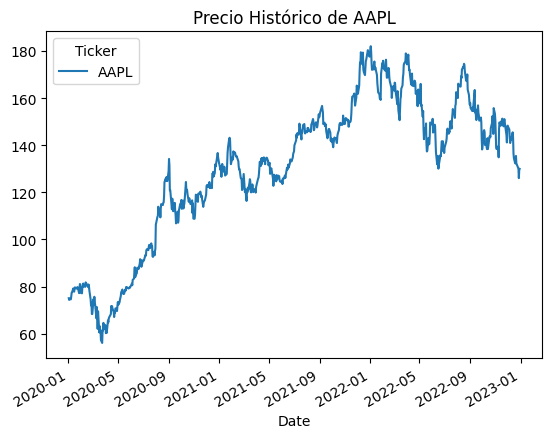

In [1]:

import yfinance as yf

# Descargar datos históricos
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
data['Close'].plot(title='Precio Histórico de AAPL')


## 2. Creación de Indicadores Técnicos

In [2]:

import pandas as pd

# Calcular Medias Móviles
data['SMA_20'] = data['Close'].rolling(window=20).mean()
data['SMA_50'] = data['Close'].rolling(window=50).mean()

# RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data)
data.dropna(inplace=True)


## 3. Ingeniería de Características y Normalización

In [3]:

from sklearn.preprocessing import StandardScaler

# Selección de características y etiquetas
X = data[['SMA_20', 'SMA_50', 'RSI']]
y = (data['Close'].shift(-1) > data['Close']).astype(int)

# Escalamiento de características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 4. División de Datos y Preservación de Índices

In [4]:

from sklearn.model_selection import train_test_split

# Dividir datos con índices preservados
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42, shuffle=False)

# Reconstruir DataFrames con índices originales
train_index = data.index[:len(X_train)]
temp_index = data.index[len(X_train):len(X_train) + len(X_temp)]
test_index = data.index[-len(X_test):]

X_train = pd.DataFrame(X_train, index=train_index)
X_test = pd.DataFrame(X_test, index=test_index)


## 5. Entrenamiento del Modelo con Validación Cruzada

In [5]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Configuración del modelo
rf = RandomForestClassifier(random_state=42)

# Definición del espacio de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Optimización de hiperparámetros
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Selección del mejor modelo
best_model = grid_search.best_estimator_

# Evaluación en validación
val_accuracy = best_model.score(X_val, y_val)
print(f"Precisión en Validación: {val_accuracy:.2f}")


e:\Marca personal\.venv\Lib\site-packages\sklearn\base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Precisión en Validación: 0.53


## 6. Generación de Señales y Evaluación en el Conjunto de Prueba

In [6]:

# Predicción del conjunto de prueba
y_pred = best_model.predict(X_test)

# Generar señales
data.loc[test_index, 'Signal'] = y_pred
data['Signal'] = data['Signal'].fillna(0)


## 7. Cálculo de Rendimientos Acumulados

In [ ]:
# Normalizar los rendimientos acumulados para que comiencen en 1 en el conjunto de prueba
initial_asset_value = data.loc[test_index, 'Asset_Cumulative_Return'].iloc[0]
initial_strategy_value = data.loc[test_index, 'Strategy_Cumulative_Return'].iloc[0]

data.loc[test_index, 'Normalized_Asset_Cumulative_Return'] = (
    data.loc[test_index, 'Asset_Cumulative_Return'] / initial_asset_value)

data.loc[test_index, 'Normalized_Strategy_Cumulative_Return'] = (
    data.loc[test_index, 'Strategy_Cumulative_Return'] / initial_strategy_value)

## 8. Visualización de Resultados

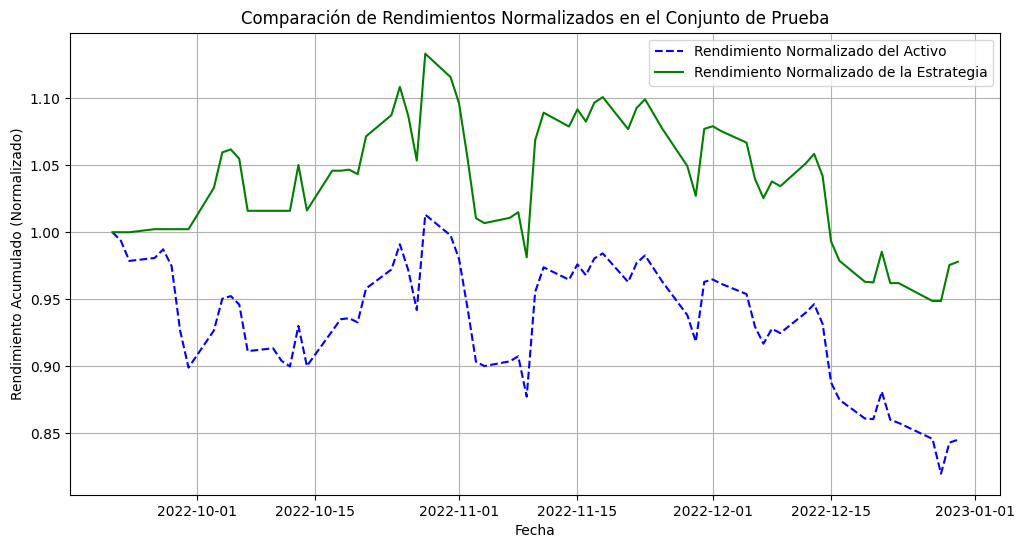

In [ ]:



# Graficar los rendimientos normalizados
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data.loc[test_index, 'Normalized_Asset_Cumulative_Return'], label='Rendimiento Normalizado del Activo', linestyle='--', color='blue')
plt.plot(data.loc[test_index, 'Normalized_Strategy_Cumulative_Return'], label='Rendimiento Normalizado de la Estrategia', color='green')
plt.title('Comparación de Rendimientos Normalizados en el Conjunto de Prueba')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento Acumulado (Normalizado)')
plt.legend()
plt.grid()
plt.show()
